In [ ]:
# default_exp model.gru

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#! pip install datasets
#! pip install tokenizers -U

In [ ]:
#HF datasets
from datasets import list_datasets, load_dataset, list_metrics, load_metric
from datasets import Dataset

In [ ]:
#HF preprocessing
from tokenizers import Tokenizer

In [ ]:
from datetime import datetime

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time

In [ ]:
#functional programming
import functools 

In [ ]:
#experimental
#import tensorflow.experimental.numpy as tnp

In [ ]:
from pathlib import Path

In [ ]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Deep Generative Coding with GRUs 
>
>@danaderp 11.17.20 This a GRU generative architecture for the CodeSearchNet dataset.
>

In [ ]:
path_data = Path('../dvc-icodegen') #dataset path
def params():
    return {
        'dummy_path' : path_data/'dummy/',
        'hyper': {
            'seq_length':100, #This Value depends on the EDA
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10
        },
        'checkpoint_dir':path_data/'models/',
        'dataset':path_data/'searchnet/[codesearchnet-java-1597073966.81902].csv',
        'eda':path_data/'eda/',
        'tokenizer':path_data/'bpe/tokenizer-java.json'
    }

In [ ]:
params = params()

In [ ]:
#tst
logging.info(params['hyper']['seq_length'])
logging.info(params['dataset'])
logging.info(params['eda'])
logging.info(params['tokenizer'])

2020-11-23 11:39:29,633 : INFO : 100
2020-11-23 11:39:29,635 : INFO : ../dvc-icodegen/searchnet/[codesearchnet-java-1597073966.81902].csv
2020-11-23 11:39:29,637 : INFO : ../dvc-icodegen/eda
2020-11-23 11:39:29,638 : INFO : ../dvc-icodegen/bpe/tokenizer-java.json


## Datasets Processing

In [ ]:
#Loading CodeSearchNet Dataset
java_df = pd.read_csv(params['dataset'], sep='~') #without bpe vectorization

In [ ]:
java_df.head(2)

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition,bpe32k,code_len,bpe32_len,bpe_ids
0,apache/spark,sql/hive-thriftserver/src/main/java/org/apache...,https://github.com/apache/spark/blob/25ee0474f...,<@>Override<n> <public> OperationHandle getSc...,"['@', 'Override', 'public', 'OperationHandle',...",/* (non-Javadoc)\n@see org.apache.hive.service...,"['/', '*', '(', 'non', '-', 'Javadoc', ')']",java,train,"['▁', '@', 'Override', '▁public', '▁Operation'...",31.0,43.0,"[83, 186, 601, 88, 187, 34, 3916, 2854, 4673, ..."
1,BlueBrain/bluima,modules/bluima_typesystem/src/main/java/de/jul...,https://github.com/BlueBrain/bluima/blob/793ea...,<public> <void> setTextObjects<(>FSArray v<)> ...,"['public', 'void', 'setTextObjects', '(', 'FSA...",setter for textObjects - sets the text objects...,"['setter', 'for', 'textObjects', '-', 'sets', ...",java,train,"['▁public', '▁void', '▁setText', 'Objects', '(...",64.0,92.0,"[34, 186, 47, 645, 989, 3718, 80, 727, 139, 54..."


### Vectorize the Tokens with BPE

Without BPE Vectorization

In [ ]:
new_tokenizer = Tokenizer.from_file( str( params['tokenizer'] ) )

In [ ]:
# The unique subwords in the dataset
vocab = sorted(set( new_tokenizer.get_vocab().keys() ))
logging.info('{} unique characters'.format( len( vocab ) ) )

2020-11-18 11:25:09,448 : INFO : 10000 unique characters


In [ ]:
logging.info( new_tokenizer.encode(' <&&> <{>< Davidcito').tokens )
logging.info( new_tokenizer.encode(' <&&> <{>< Davidcito').ids )
logging.info( new_tokenizer.encode('  ').tokens )
logging.info( new_tokenizer.encode('  ').ids )
logging.info( new_tokenizer.encode('🤗').tokens )
logging.info( new_tokenizer.encode('🤗').ids )

2020-11-23 20:58:32,841 : INFO : ['Ġ', '<&&>', 'Ġ', '<{>', 'Ġ<', 'ĠD', 'av', 'id', 'c', 'it', 'o']
2020-11-23 20:58:32,844 : INFO : [186, 65, 186, 76, 190, 546, 1869, 287, 155, 258, 167]
2020-11-23 20:58:32,845 : INFO : ['ĠĠ']
2020-11-23 20:58:32,846 : INFO : [187]
2020-11-23 20:58:32,848 : INFO : ['Ġ']
2020-11-23 20:58:32,849 : INFO : [186]


In [ ]:
logging.info( new_tokenizer.encode( java_df.code.values[0] ).ids )

2020-11-23 11:42:13,228 : INFO : [83, 186, 601, 88, 187, 34, 3916, 2854, 4673, 1172, 349, 80, 5260, 2854, 1738, 2854, 100, 334, 242, 4739, 319, 100, 88, 300, 334, 2890, 319, 81, 186, 44, 726, 713, 5158, 186, 76, 88, 188, 35, 242, 474, 714, 102, 959, 1172, 349, 80, 1738, 2854, 100, 242, 4739, 319, 100, 2890, 319, 81, 82, 88, 187, 77]


In [ ]:
#This is the optimal way
output = new_tokenizer.encode_batch(
    [["Hello, y'all!", "How are you 😁 ?"], ["Hello to you too!", "I'm fine, thank you!"]]
)

In [ ]:
java_df['bpe_ids'] = [ new_tokenizer.encode( str(m) ).ids for m in java_df.code.values] #Run this once

In [ ]:
timestamp = datetime.timestamp(datetime.now())
timestamp

1605759118.768157

In [ ]:
java_df.to_csv('../dvc-icodegen/searchnet/'+'[{}]-codesearchnet_java_bpe10k.csv'.format(timestamp), sep='~')

With BPE Vectorization

In [ ]:
java_df = pd.read_csv(path_data/'searchnet/[1605759118.768157]-codesearchnet_java_bpe10k.csv', sep='~', index_col=0) #with bpe vectorization

In [ ]:
# Partitions
df_train = java_df[java_df['partition'] == 'train']
df_valid = java_df[java_df['partition'] == 'valid']
df_test = java_df[java_df['partition'] == 'test']

In [ ]:
logging.info("Train Partition Size "+ str(df_train.shape) )
logging.info("Valid Partition Size "+ str(df_valid.shape) )
logging.info("Test Partition Size "+ str(df_test.shape) )

2020-11-23 12:58:29,736 : INFO : Train Partition Size (384868, 13)
2020-11-23 12:58:29,737 : INFO : Valid Partition Size (14605, 13)
2020-11-23 12:58:29,738 : INFO : Test Partition Size (25011, 13)


In [ ]:
tokenizer_len = [len( eval(elem) ) for elem in df_train.bpe_ids.values] #Len of a method BECAREFUL when reading with BPE

In [ ]:
tokenizer_max_len = max( tokenizer_len ) #Max Len of a method
tokenizer_min_len = min( tokenizer_len ) #Min Len of a method

In [ ]:
logging.info("tokenizer_max_len "+ str( tokenizer_max_len ) )
logging.info("tokenizer_min_len "+ str( tokenizer_min_len ) )

2020-11-23 14:17:20,068 : INFO : tokenizer_max_len 85184
2020-11-23 14:17:20,069 : INFO : tokenizer_min_len 26


In [ ]:
df_train['tokenizer_len'] = tokenizer_len

/home/danaderp/.conda/envs/icodegen/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


*The prediction task*

Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

In [ ]:
#Testing Decoder 
logging.info( df_train.code.values[0] ) 
logging.info( df_train.bpe_ids.values[0] ) 
logging.info( new_tokenizer.decode( eval( df_train.bpe_ids.values[0]) , skip_special_tokens=False ) ) #Enable special Tokens!
logging.info( new_tokenizer.decode( [0 ,1 ,0 ] , skip_special_tokens=False ) ) #Enable special Tokens!

2020-11-23 20:44:22,115 : INFO : <@>Override<n>  <public> OperationHandle getSchemas<(>SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(>sessionHandle, catalogName, schemaName<)><;><n>  <}>
2020-11-23 20:44:22,116 : INFO : [83, 186, 601, 88, 187, 34, 3916, 2854, 4673, 1172, 349, 80, 5260, 2854, 1738, 2854, 100, 334, 242, 4739, 319, 100, 88, 300, 334, 2890, 319, 81, 186, 44, 726, 713, 5158, 186, 76, 88, 188, 35, 242, 474, 714, 102, 959, 1172, 349, 80, 1738, 2854, 100, 242, 4739, 319, 100, 2890, 319, 81, 82, 88, 187, 77]
2020-11-23 20:44:22,118 : INFO : <@> Override<n>  <public> OperationHandle getSchemas<(> SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(> sessionHandle, catalogName, schemaName<)><;><n>  <}>
2020-11-23 20:44:22,119 : INFO : <abstract><assert><abstract>


## EDA 
to determine the number of features in the tensor. Do not confuse with the number of batch. 

In [ ]:
df_train.describe().round(2)

,code_len,bpe32_len,tokenizer_len
count,384868.00,384868.00,384868.00
mean,113.72,147.15,234.01
std,194.01,313.90,493.64
min,20.00,20.00,26.00
25%,42.00,50.00,78.00
50%,67.00,81.00,128.00
75%,122.00,151.00,243.00
max,27192.00,52975.00,85184.00


In [ ]:
df_train.quantile(q=0.8)

code_len         144.0
bpe32_len        180.0
tokenizer_len    290.0
Name: 0.8, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f31b980bf90>,
      dtype=object)

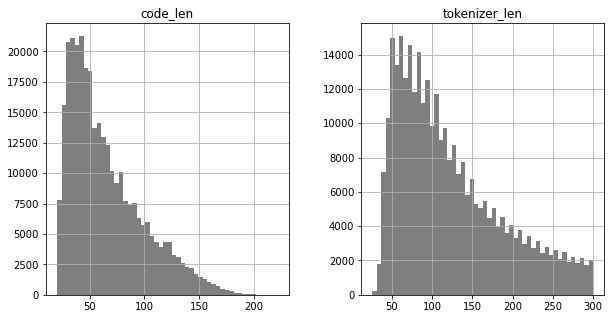

In [ ]:
MAX_SEQ = 300
df_train[df_train['tokenizer_len']<=MAX_SEQ].hist(column=['tokenizer_len', 'code_len'],color='k',bins=50,figsize=[10,5],alpha=0.5)

### Tensorflow Datasets [Default]

In [ ]:
df_temp = df_train.take([0,-1,384867])

In [ ]:
df_temp

,repo,path,url,code,code_tokens,docstring,docstring_tokens,language,partition,bpe32k,code_len,bpe32_len,bpe_ids
0,apache/spark,sql/hive-thriftserver/src/main/java/org/apache...,https://github.com/apache/spark/blob/25ee0474f...,<@>Override<n> <public> OperationHandle getSc...,"['@', 'Override', 'public', 'OperationHandle',...",/* (non-Javadoc)\n@see org.apache.hive.service...,"['/', '*', '(', 'non', '-', 'Javadoc', ')']",java,train,"['▁', '@', 'Override', '▁public', '▁Operation'...",31.0,43.0,"[83, 186, 601, 88, 187, 34, 3916, 2854, 4673, ..."
634927,elki-project/elki,elki-outlier/src/main/java/de/lmu/ifi/dbs/elki...,https://github.com/elki-project/elki/blob/b546...,<protected> <static> <double> sparsity<(><fina...,"['protected', 'static', 'double', 'sparsity', ...",Method to calculate the sparsity coefficient o...,"['Method', 'to', 'calculate', 'the', 'sparsity...",java,train,"['▁protected', '▁static', '▁double', '▁sparsit...",65.0,76.0,"[33, 186, 37, 186, 13, 273, 773, 171, 489, 80,..."
634927,elki-project/elki,elki-outlier/src/main/java/de/lmu/ifi/dbs/elki...,https://github.com/elki-project/elki/blob/b546...,<protected> <static> <double> sparsity<(><fina...,"['protected', 'static', 'double', 'sparsity', ...",Method to calculate the sparsity coefficient o...,"['Method', 'to', 'calculate', 'the', 'sparsity...",java,train,"['▁protected', '▁static', '▁double', '▁sparsit...",65.0,76.0,"[33, 186, 37, 186, 13, 273, 773, 171, 489, 80,..."


*Masking* is a way to tell sequence-processing layers that certain timesteps in an input are missing, and thus should be skipped when processing the data.

*Padding* is a special form of masking where the masked steps are at the start or at the beginning of a sequence. Padding comes from the need to encode sequence data into contiguous batches: in order to make all sequences in a batch fit a given standard length, it is necessary to pad or truncate some sequences.

In [ ]:
#Resizing Methods
# It is recommended to use "post" padding when working with RNN layers
# (in order to be able to use the
# CuDNN implementation of the layers).
#For a padding reference check https://stackoverflow.com/questions/35751306/python-how-to-pad-numpy-array-with-zeros
def method_resize(np_non_rec, len_seq):
    """This function recieves a vector of encoded methods and resized according to a length sequence
    the length sequence es the number of columns or features
    The function takes a non-rectangular tensor and transforms it into a rectangular one
    """
    rows = int(np.ceil( np_non_rec.shape[0]  / len_seq )) #Minimum # of rows to complete/shape the sequence
    pad_diff = (rows * len_seq) - np_non_rec.shape[0] #1D required sequence minus the shape of the original tensor
    np_rec = np.pad(np_non_rec, [(0, pad_diff ),] , mode='constant', constant_values=0 ) #np padding
    np_rec = np.reshape( np_rec, (rows , len_seq) ) #Reshaping The Tensor
    return np_rec

In [ ]:
#The Following Function summarizes all the method transformation into sequences
def method2seq(raw_inputs, seq_length ):
    '''This Function generated the conceptual decomposition of a method into 
    a sequence or sequences given a max-len.
    # The method2seq method lets us easily convert these individual methods to sequences of the desired size.'''
    np_raw_inputs = [np.array( eval(m) ) for m in raw_inputs] #Extracting/Evaluating the tensors stored in pandas
    np_resized_inputs = [ method_resize( m, seq_length ) for m in np_raw_inputs ] #Resizing methods 
    np_resized_inputs = functools.reduce(lambda a,b :np.concatenate((a,b), axis=0), np_resized_inputs ) #Merging Decomposed Sequences
    return tf.data.Dataset.from_tensor_slices( np_resized_inputs )

#### Testing Tensorflow Datasets

In [ ]:
tf_sequences_train = method2seq( df_temp.bpe_ids.values, MAX_SEQ )
list(tf_sequences_train.as_numpy_iterator()) #TST

[array([  83,  186,  601,   88,  187,   34, 3916, 2854, 4673, 1172,  349,
          80, 5260, 2854, 1738, 2854,  100,  334,  242, 4739,  319,  100,
          88,  300,  334, 2890,  319,   81,  186,   44,  726,  713, 5158,
         186,   76,   88,  188,   35,  242,  474,  714,  102,  959, 1172,
         349,   80, 1738, 2854,  100,  242, 4739,  319,  100, 2890,  319,
          81,   82,   88,  187,   77,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [ ]:
for i in tf_sequences_train.take(3):
    print( new_tokenizer.decode( i.numpy() , skip_special_tokens=False ) )

<@> Override<n>  <public> OperationHandle getSchemas<(> SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(> sessionHandle, catalogName, schemaName<)><;><n>  <}><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abs

### HuggingFace Datasets [Not recommended]

In [ ]:
# Loading from In-Memory Data
hf_train_java = Dataset.from_pandas(df_temp)

In [ ]:
hf_train_java

Dataset(features: {'repo': Value(dtype='string', id=None), 'path': Value(dtype='string', id=None), 'url': Value(dtype='string', id=None), 'code': Value(dtype='string', id=None), 'code_tokens': Value(dtype='string', id=None), 'docstring': Value(dtype='string', id=None), 'docstring_tokens': Value(dtype='string', id=None), 'language': Value(dtype='string', id=None), 'partition': Value(dtype='string', id=None), 'bpe32k': Value(dtype='string', id=None), 'code_len': Value(dtype='float64', id=None), 'bpe32_len': Value(dtype='float64', id=None), 'bpe_ids': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}, num_rows: 3)

In [ ]:
hf_train_java['bpe_ids'][0]

'[83, 186, 601, 88, 187, 34, 3916, 2854, 4673, 1172, 349, 80, 5260, 2854, 1738, 2854, 100, 334, 242, 4739, 319, 100, 88, 300, 334, 2890, 319, 81, 186, 44, 726, 713, 5158, 186, 76, 88, 188, 35, 242, 474, 714, 102, 959, 1172, 349, 80, 1738, 2854, 100, 242, 4739, 319, 100, 2890, 319, 81, 82, 88, 187, 77]'

In [ ]:
hf_train_java.set_format(type='tensorflow', columns=['bpe_ids'])

In [ ]:
#A Dictionary of Features
train_features = {x: hf_train_java[x].to_tensor(default_value=0, shape=[ None, tokenizer_max_len ]) for x in ['bpe_ids']}

AttributeError: 'list' object has no attribute 'to_tensor'

In [ ]:
type(train_features['bpe_ids'])

tensorflow.python.framework.ops.EagerTensor

In [ ]:
# Create training examples / targets
tfdataset = tf.data.Dataset.from_tensor_slices((features, hf_train_java["bpe_ids"]))

## Create training examples and targets

In [ ]:
# The maximum length sentence we want for a single input in characters
seq_length = MAX_SEQ 
#seq_length = params['hyper']['seq_length'] 
#examples_per_epoch = len(text)//(seq_length+1) 

For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [ ]:
#dataset = sequences.map(split_input_target)
dataset = tf_sequences_train.map( split_input_target ) #TST <----- Deactivate when using the big dataset

In [ ]:
#Print the first example input and target values:
for input_example, target_example in  dataset.take(1):
    print('Input data: ', new_tokenizer.decode( input_example.numpy() , skip_special_tokens=False ) )
    print('Target data:', new_tokenizer.decode( target_example.numpy() , skip_special_tokens=False ) )

Input data:  <@> Override<n>  <public> OperationHandle getSchemas<(> SessionHandle sessionHandle, String catalogName,<n>      String schemaName<)> <throws> HiveSQLException <{><n>    <return> cliService.getSchemas<(> sessionHandle, catalogName, schemaName<)><;><n>  <}><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><abstract><

Each index of these vectors is processed as a one time step. For the input at time step 0, the model receives the index for "<@>" and tries to predict the index for "Override" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.